In [6]:
import pandas as pd

import plotly.express as px
from dash import Dash, dcc, html

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os

In [7]:
from src.constants import AFRICAN_COUNTRIES
from src.data_loader import DATA_DIR

In [8]:
datapath = os.path.join(DATA_DIR, 'GEDEvent_v25_1.csv')
df = pd.read_csv(datapath)

df.head()

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/3896875466.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datapath)


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,244657,IRQ-2017-1-524-322,2017,True,Clear,1,259,259,Iraq: Government,524,...,2017-07-31 00:00:00.000,0,4,0,2,6,6,6,645,NaN
1,412700,IRQ-2021-1-524-145,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-26 00:00:00.000,13,1,141,28,183,184,171,645,NaN
2,413023,IRQ-2021-1-524-143,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-28 00:00:00.000,0,2,0,0,2,3,0,645,NaN
3,412909,IRQ-2021-1-524-144,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-29 00:00:00.000,0,0,10,0,10,10,9,645,NaN
4,132140,AFG-1989-1-411-2,1989,True,Clear,1,333,333,Afghanistan: Government,724,...,1989-01-13 00:00:00.000,6,0,0,0,6,6,6,700,NaN


In [9]:
df.columns

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

In [10]:
conflict_data_africa = df[df['country'].isin(AFRICAN_COUNTRIES)]

<Axes: >

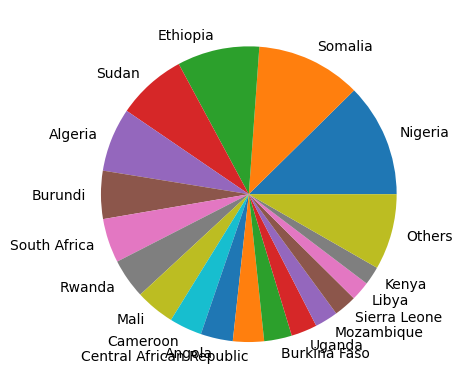

In [11]:
counts = conflict_data_africa['country'].value_counts()
pct = counts / counts.sum()
others = pct[pct < 0.02].sum()
main = pct[pct >= 0.02]
country_overview = pd.concat([main, pd.Series({'Others': others})])
country_overview.plot(kind="pie")

<Axes: >

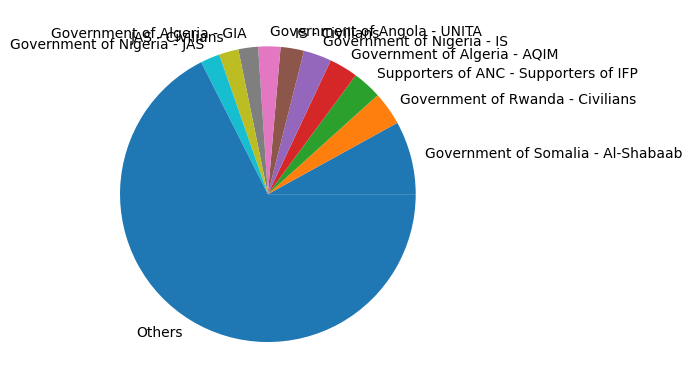

In [12]:
counts = conflict_data_africa['dyad_name'].value_counts()
pct = counts / counts.sum()
others = pct[pct < 0.02].sum()
main = pct[pct >= 0.02]
country_overview = pd.concat([main, pd.Series({'Others': others})])
country_overview.plot(kind="pie")

<Axes: xlabel='year'>

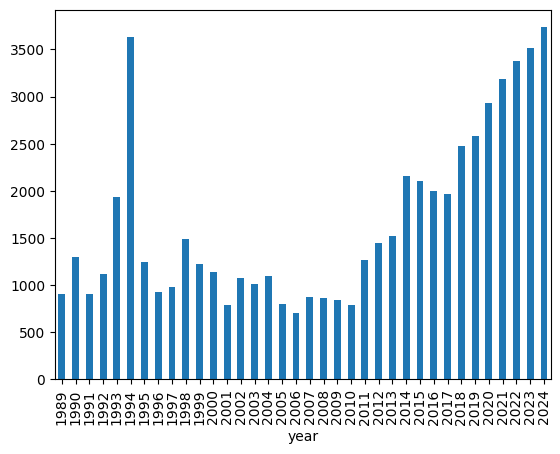

In [13]:
conflict_data_africa['year'].value_counts().sort_index().plot(kind="bar")

In [14]:
# usefull stats
sum_death = conflict_data_africa.groupby('where_coordinates')['best'].sum()
conflict_data_africa.loc[:,'frequency'] = conflict_data_africa['where_coordinates'].map(sum_death)
median_no_death_over_locations = conflict_data_africa.frequency.median()
std_no_of_death_over_locations = conflict_data_africa.frequency.std()
conflict_data_africa.loc[:,'z_scores'] = (conflict_data_africa.loc[:,'frequency'] - median_no_death_over_locations) / std_no_of_death_over_locations

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1786743065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflict_data_africa.loc[:,'frequency'] = conflict_data_africa['where_coordinates'].map(sum_death)
/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1786743065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflict_data_africa.loc[:,'z_scores'] = (conflict_data_africa.loc[:,'frequency'] - median_no_death_over_locations) / std_no_of_death_over_locations


<Axes: xlabel='year'>

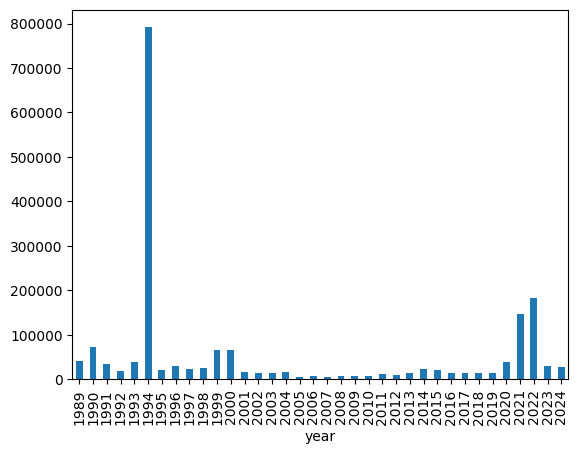

In [15]:
conflict_data_africa.groupby('year')['best'].sum().sort_index().plot(kind="bar")

In [16]:
# Precompute frequency per year
def preprocess_year(df, year):
    df_year = df[df['year'] == year].copy()
    no_death = df_year.groupby('where_coordinates')['best'].sum()
    df_year.loc[:,'frequency_year'] = conflict_data_africa['where_coordinates'].map(no_death)
    df_year.loc[:,'z_scores'] = (df_year['frequency_year'] - median_no_death_over_locations) / std_no_of_death_over_locations
    return df_year[df_year['z_scores'] > 0]

# Unique years
years = sorted(conflict_data_africa['year'].unique())

# Dash App
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Conflict Hotspots in Africa by Year"),
    dcc.Slider(
        min=min(years),
        max=max(years),
        step=1,
        marks={str(year): str(year) for year in years},
        value=min(years),
        id='year-slider'
    ),
    html.Div([
        dcc.Graph(id='heatmap'),
        dcc.Graph(id='zoomed-heatmap')
    ], style={'display': 'flex', 'flexDirection': 'row'})
])

from dash.dependencies import Output, Input

@app.callback(
    Output('heatmap', 'figure'),
    Output('zoomed-heatmap', 'figure'),
    Input('year-slider', 'value')
)
def update_maps(selected_year):
    df_filtered = preprocess_year(conflict_data_africa, selected_year)

    # Global heatmap
    fig_global = px.density_mapbox(
        df_filtered,
        lat='latitude',
        lon='longitude',
        z='z_scores',
        radius=15,
        center=dict(lat=conflict_data_africa['latitude'].mean(), lon=conflict_data_africa['longitude'].mean()),
        zoom=1,
        mapbox_style="carto-positron",
        title=f"Conflict Hotspots - {selected_year} (Global View)"
    )

    # Zoomed-in heatmap - find densest point
    top_location = df_filtered.groupby(['latitude', 'longitude'])['z_scores'].mean().idxmax()
    center_lat, center_lon = top_location

    fig_zoomed = px.density_mapbox(
        df_filtered,
        lat='latitude',
        lon='longitude',
        z='z_scores',
        radius=15,
        center=dict(lat=center_lat, lon=center_lon),
        zoom=4,  
        mapbox_style="carto-positron",
        title=f"Conflict Hotspots - {selected_year} (Zoomed View)"
    )

    return fig_global, fig_zoomed

if __name__ == '__main__':
    app.run(debug=True)


/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1844984550.py:41: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1844984550.py:57: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1844984550.py:41: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1844984550.py:57: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1844984550.py:41: DeprecationWarnin

In [17]:
conflict_data_africa['date'] = pd.to_datetime(conflict_data_africa['date_start'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')


/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_36917/1308375574.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



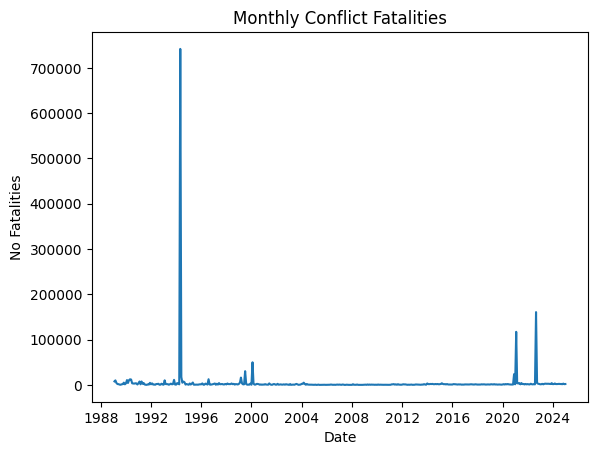

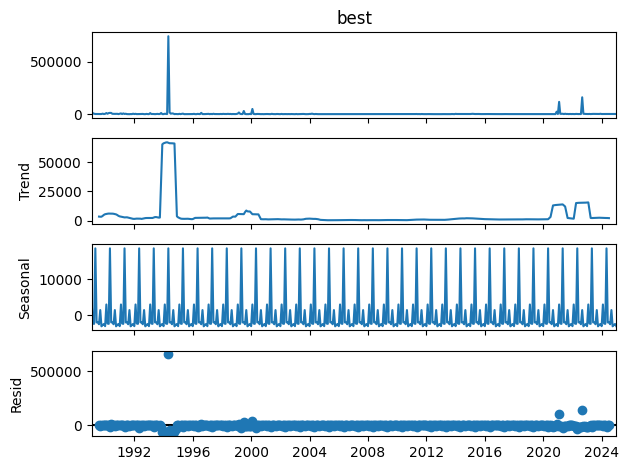

In [18]:
conflict_ts = conflict_data_africa.groupby('date')['best'].sum().sort_index()

# 'M' for monthly
monthly_counts = conflict_ts.resample('ME').sum()

# Plot resampled time series
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title("Monthly Conflict Fatalities")
plt.xlabel("Date")
plt.ylabel("No Fatalities")
plt.show()

# Decompose
decompose = seasonal_decompose(monthly_counts, model='additive', period=12) 
decompose.plot()
plt.show()


4359.430555555556
134
741786


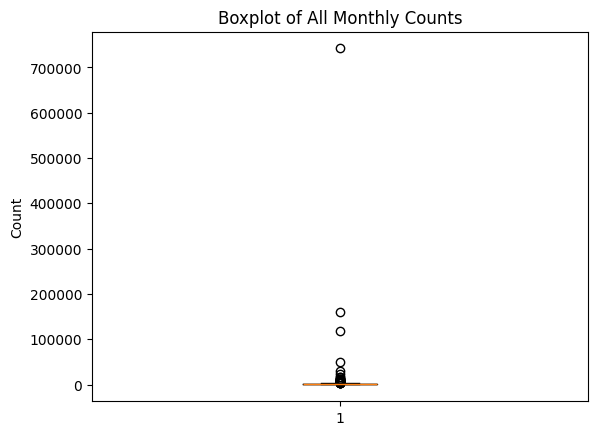

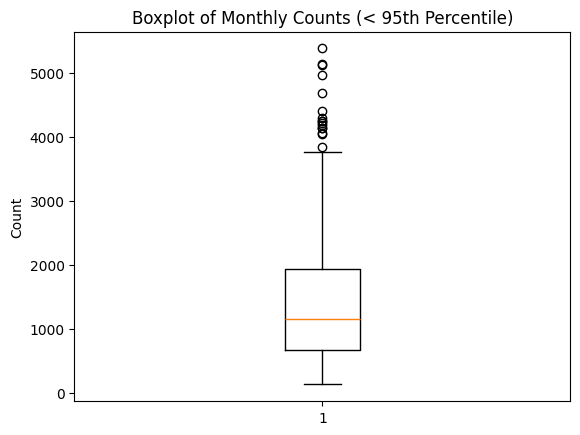

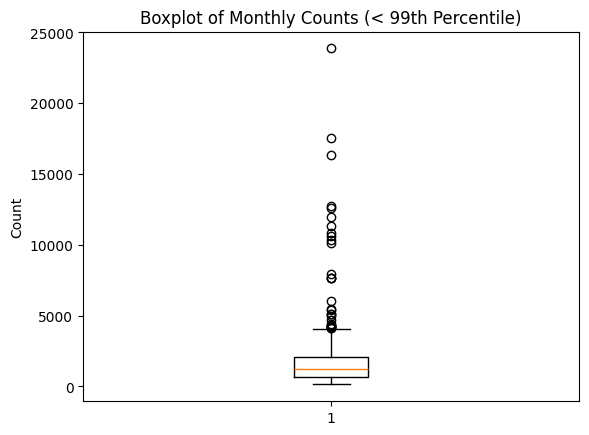

In [19]:
print(monthly_counts.values.mean())
print(monthly_counts.values.min())
print(monthly_counts.values.max())

# Boxplot of all values
plt.boxplot(monthly_counts.values)
plt.title("Boxplot of All Monthly Counts")
plt.ylabel("Count")
plt.show()  # ← must include parentheses to display the plot

# Filtered values (below 75th percentile)
filtered_values = monthly_counts[monthly_counts < monthly_counts.quantile(0.95)]

# Boxplot of filtered values
plt.boxplot(filtered_values.values)
plt.title("Boxplot of Monthly Counts (< 95th Percentile)")
plt.ylabel("Count")
plt.show()  # ← again, call the function with ()

# Filtered values (below 75th percentile)
filtered_values = monthly_counts[monthly_counts < monthly_counts.quantile(0.99)]

# Boxplot of filtered values
plt.boxplot(filtered_values.values)
plt.title("Boxplot of Monthly Counts (< 99th Percentile)")
plt.ylabel("Count")
plt.show()  # ← again, call the function with ()

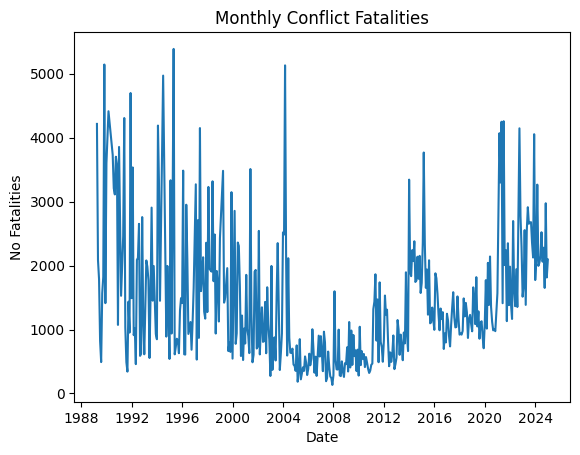

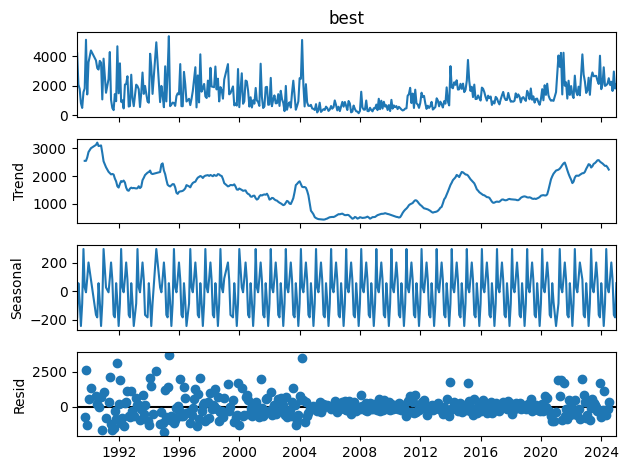

In [20]:
monthly_counts = monthly_counts[monthly_counts < monthly_counts.quantile(0.95)]

# Plot resampled time series
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title("Monthly Conflict Fatalities")
plt.xlabel("Date")
plt.ylabel("No Fatalities")
plt.show()

# Decompose
decompose = seasonal_decompose(monthly_counts, model='additive', period=12) 
decompose.plot()
plt.show()

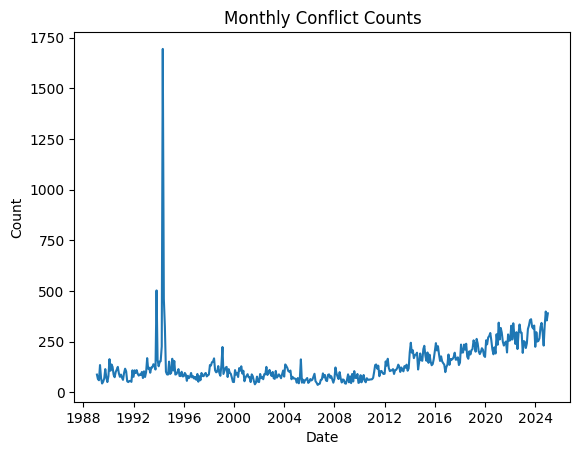

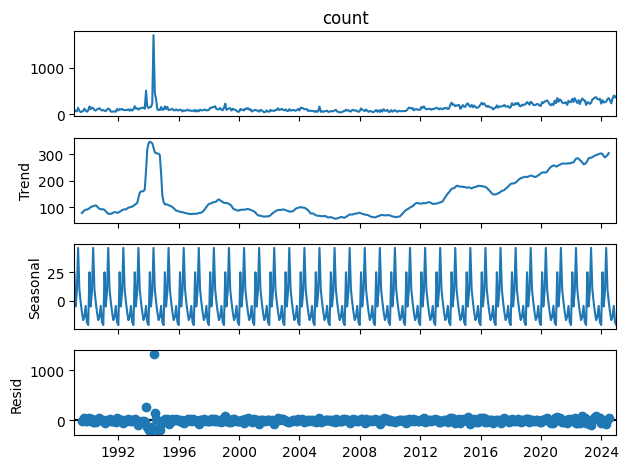

In [21]:
conflict_ts = conflict_data_africa.date.value_counts().sort_index()

# 'M' for monthly
monthly_counts = conflict_ts.resample('ME').sum()

# Plot resampled time series
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title("Monthly Conflict Counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

# Decompose
decompose = seasonal_decompose(monthly_counts, model='additive', period=12) 
decompose.plot()
plt.show()